In [32]:
import os
import glob
import json
import random
from pathlib import Path
from difflib import SequenceMatcher

import cv2
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from IPython.display import display
import matplotlib
from matplotlib import pyplot, patches

In [33]:
#/kaggle/input/sroie-tesing/

sroie_folder_path = Path('/kaggle/input/sroie-testing/SROIE2019')
example_file = Path('X51005365187.txt')

In [34]:
def read_bbox_and_words(path: Path):
  bbox_and_words_list = []

  with open(path, 'r', errors='ignore') as f:
    for line in f.read().splitlines():
      if len(line) == 0:
        continue
        
      split_lines = line.split(",")

      bbox = np.array(split_lines[0:8], dtype=np.int32)
      text = ",".join(split_lines[8:])
      bbox_and_words_list.append([path.stem, *bbox, text])
    
  dataframe = pd.DataFrame(bbox_and_words_list, columns=['filename', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'line'], dtype=np.int16)
  dataframe = dataframe.drop(columns=['x1', 'y1', 'x3', 'y3'])

  return dataframe

In [35]:
bbox_file_path = sroie_folder_path / "test/box" / example_file
print("File content-")
!head -n 5 "{bbox_file_path}"

bbox = read_bbox_and_words(path=bbox_file_path)
print("\nDataframe-")
bbox.head(5)

== File content ==
17,35,371,35,371,91,17,91,3-1707067
222,115,511,115,511,143,222,143,F&P PHARMACY
274,148,457,148,457,174,274,174,(002309592-P)
204,183,529,183,529,210,204,210,NO.20. GROUND FLOOR,
99,218,632,218,632,244,99,244,JALAN BS 10/6 TAMAN BUKIT SERDANG,

== Dataframe ==


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  """


,filename,x0,y0,x2,y2,line
0,X51005365187,17,35,371,91,3-1707067
1,X51005365187,222,115,511,143,F&P PHARMACY
2,X51005365187,274,148,457,174,(002309592-P)
3,X51005365187,204,183,529,210,"NO.20. GROUND FLOOR,"
4,X51005365187,99,218,632,244,"JALAN BS 10/6 TAMAN BUKIT SERDANG,"


In [36]:
def read_entities(path: Path):
  with open(path, 'r') as f:
    data = json.load(f)

  dataframe = pd.DataFrame([data])
  return dataframe


<h1>Example</h1>

In [37]:
entities_file_path = sroie_folder_path /  "test/entities" / example_file
print("== File content ==")
!head "{entities_file_path}"

entities = read_entities(path=entities_file_path)
print("\n\n== Dataframe ==")
entities

== File content ==
{
    "company": "F&P PHARMACY",
    "date": "02/03/2018",
    "address": "NO.20. GROUND FLOOR, JALAN BS 10/6 TAMAN BUKIT SERDANG, SEKSYEN 10, 43300 SERI KEMBANGAN. SELANGOR DARUL EHSAN",
    "total": "31.90"
}

== Dataframe ==


,company,date,address,total
0,F&P PHARMACY,02/03/2018,"NO.20. GROUND FLOOR, JALAN BS 10/6 TAMAN BUKIT...",31.90


<h1>Assign labels to words using the entities data</h1>

In [38]:


# Assign a label to the line by checking the similarity of the line and all the entities
def assign_line_label(line: str, entities: pd.DataFrame):
    line_set = line.replace(",", "").strip().split()
    for i, column in enumerate(entities):
        entity_values = entities.iloc[0, i].replace(",", "").strip()
        entity_set = entity_values.split()
        
        
        matches_count = 0
        for l in line_set:
            if any(SequenceMatcher(a=l, b=b).ratio() > 0.8 for b in entity_set):
                matches_count += 1
            
            if (column.upper() == 'ADDRESS' and (matches_count / len(line_set)) >= 0.5) or \
               (column.upper() != 'ADDRESS' and (matches_count == len(line_set))) or \
               matches_count == len(entity_set):
                return column.upper()

    return "O"


line = bbox.loc[1,"line"]
label = assign_line_label(line, entities)
print("Line:", line)
print("Assigned label:", label)

Line: F&P PHARMACY
Assigned label: COMPANY


In [39]:
def assign_labels(words: pd.DataFrame, entities: pd.DataFrame):
    max_area = {"TOTAL": (0, -1), "DATE": (0, -1)}  # Value, index
    already_labeled = {"TOTAL": False,
                       "DATE": False,
                       "ADDRESS": False,
                       "COMPANY": False,
                       "O": False
    }

    # Go through every line in words and assign it a label
    labels = []
    for i, line in enumerate(words['line']):
        label = assign_line_label(line, entities)

        already_labeled[label] = True
        if (label == "ADDRESS" and already_labeled["TOTAL"]) or \
           (label == "COMPANY" and (already_labeled["DATE"] or already_labeled["TOTAL"])):
            label = "O"

        # Assign to the largest bounding box
        if label in ["TOTAL", "DATE"]:
            x0_loc = words.columns.get_loc("x0")
            bbox = words.iloc[i, x0_loc:x0_loc+4].to_list()
            area = (bbox[2] - bbox[0]) + (bbox[3] - bbox[1])

            if max_area[label][0] < area:
                max_area[label] = (area, i)

            label = "O"

        labels.append(label)

    labels[max_area["DATE"][1]] = "DATE"
    labels[max_area["TOTAL"][1]] = "TOTAL"

    words["label"] = labels
    return words


# Example usage
bbox_labeled = assign_labels(bbox, entities)
bbox_labeled.head(15)

,filename,x0,y0,x2,y2,line,label
0,X51005365187,17,35,371,91,3-1707067,O
1,X51005365187,222,115,511,143,F&P PHARMACY,COMPANY
2,X51005365187,274,148,457,174,(002309592-P),O
3,X51005365187,204,183,529,210,"NO.20. GROUND FLOOR,",ADDRESS
4,X51005365187,99,218,632,244,"JALAN BS 10/6 TAMAN BUKIT SERDANG,",ADDRESS
5,X51005365187,111,250,623,275,"SEKSYEN 10, 43300 SERI KEMBANGAN,",ADDRESS
6,X51005365187,186,284,538,308,SELANGOR DARUL EHSAN,ADDRESS
7,X51005365187,251,316,484,339,TEL 03-89599823,O
8,X51005365187,182,351,346,378,GST REG NO,O
9,X51005365187,274,387,461,409,TAX INVOICE,O


In [40]:
def split_line(line: pd.Series):
  line_copy = line.copy()

  line_str = line_copy.loc["line"]
  words = line_str.split(" ")

  # Filter unwanted tokens
  words = [word for word in words if len(word) >= 1]

  x0, y0, x2, y2 = line_copy.loc[['x0', 'y0', 'x2', 'y2']]
  bbox_width = x2 - x0
  

  new_lines = []
  for index, word in enumerate(words):
    x2 = x0 + int(bbox_width * len(word)/len(line_str))
    line_copy.at['x0', 'x2', 'line'] = [x0, x2, word]
    new_lines.append(line_copy.to_list())
    x0 = x2 + 5 

  return new_lines


# Example usage
new_lines = split_line(bbox_labeled.loc[1])
print("Original row:")
display(bbox_labeled.loc[1:1,:])

print("Splitted row:")
pd.DataFrame(new_lines, columns=bbox_labeled.columns)

Original row:


,filename,x0,y0,x2,y2,line,label
1,X51005365187,222,115,511,143,F&P PHARMACY,COMPANY


Splitted row:


,filename,x0,y0,x2,y2,line,label
0,X51005365187,222,115,294,143,F&P,COMPANY
1,X51005365187,299,115,491,143,PHARMACY,COMPANY


In [41]:
from time import perf_counter
def dataset_creator(folder: Path):
  bbox_folder = folder / 'box'
  entities_folder = folder / 'entities'
  img_folder = folder / 'img'

  # Sort by filename so that when zipping them together
  # we don't get some other file (just in case)
  entities_files = sorted(entities_folder.glob("*.txt"))
  bbox_files = sorted(bbox_folder.glob("*.txt"))
  img_files = sorted(img_folder.glob("*.jpg"))

  data = []

  print("Reading dataset:")
  for bbox_file, entities_file, img_file in tqdm(zip(bbox_files, entities_files, img_files), total=len(bbox_files)):            
    # Read the files
    bbox = read_bbox_and_words(bbox_file)
    entities = read_entities(entities_file)
    image = Image.open(img_file)

    # Assign labels to lines in bbox using entities
    bbox_labeled = assign_labels(bbox, entities)
    del bbox

    # Split lines into separate tokens
    new_bbox_l = []
    for index, row in bbox_labeled.iterrows():
      new_bbox_l += split_line(row)
    new_bbox = pd.DataFrame(new_bbox_l, columns=bbox_labeled.columns, dtype=np.int16)
    del bbox_labeled


    # Do another label assignment to keep the labeling more precise 
    for index, row in new_bbox.iterrows():
      label = row['label']

      if label != "O":
        entity_values = entities.iloc[0, entities.columns.get_loc(label.lower())]
        entity_set = entity_values.split()
        
        if any(SequenceMatcher(a=row['line'], b=b).ratio() > 0.7 for b in entity_set):
            label = "S-" + label
        else:
            label = "O"
      
      new_bbox.at[index, 'label'] = label

    width, height = image.size
  
    data.append([new_bbox, width, height])

  return data

In [42]:
dataset_train = dataset_creator(sroie_folder_path / 'train')
dataset_test = dataset_creator(sroie_folder_path / 'test')

Reading dataset:


  0%|          | 0/626 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  """Entry point for launching an IPython kernel.
100%|██████████| 626/626 [01:30<00:00,  6.94it/s]


Reading dataset:


  0%|          | 0/347 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Could not cast to int16, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  
100%|██████████| 347/347 [00:48<00:00,  7.17it/s]


In [43]:
exmpl = dataset_train[1]
exmpl

[         filename   x0   y0   x2   y2       line      label
 0    X00016469619   76   50  133   84        TAN          O
 1    X00016469619  138   50  214   84       WOON          O
 2    X00016469619  219   50  295   84       YANN          O
 3    X00016469619  110  165  156  188      INDAH  S-COMPANY
 4    X00016469619  161  165  198  188       GIFT  S-COMPANY
 ..            ...  ...  ...  ...  ...        ...        ...
 97   X00016469619   62  940  127  958    DEALING          O
 98   X00016469619  132  940  150  958         IN          O
 99   X00016469619  155  940  239  958  WHOLESALE          O
 100  X00016469619  244  940  272  958        AND          O
 101  X00016469619  277  940  342  958    RETAIL.          O
 
 [102 rows x 7 columns],
 439,
 1004]

In [44]:
def normalize(points: list, width: int, height: int) -> list:
  x0, y0, x2, y2 = [int(p) for p in points]
  
  x0 = int(1000 * (x0 / width))
  x2 = int(1000 * (x2 / width))
  y0 = int(1000 * (y0 / height))
  y2 = int(1000 * (y2 / height))

  return [x0, y0, x2, y2]


def write_dataset(dataset: list, output_dir: Path, name: str):
  print(f"Writing {name}ing dataset:")
  with open(output_dir / f"{name}.txt", "w+", encoding="utf8") as file, \
       open(output_dir / f"{name}_box.txt", "w+", encoding="utf8") as file_bbox, \
       open(output_dir / f"{name}_image.txt", "w+", encoding="utf8") as file_image:

      # Go through each dataset
      for datas in tqdm(dataset, total=len(dataset)):
        data, width, height = datas
        
        filename = data.iloc[0, data.columns.get_loc('filename')]

        # Go through every row in dataset
        for index, row in data.iterrows():
          bbox = [int(p) for p in row[['x0', 'y0', 'x2', 'y2']]]
          normalized_bbox = normalize(bbox, width, height)

          file.write("{}\t{}\n".format(row['line'], row['label']))
          file_bbox.write("{}\t{} {} {} {}\n".format(row['line'], *normalized_bbox))
          file_image.write("{}\t{} {} {} {}\t{} {}\t{}\n".format(row['line'], *bbox, width, height, filename))

        # Write a second newline to separate dataset from others
        file.write("\n")
        file_bbox.write("\n")
        file_image.write("\n")

In [45]:
dataset_directory = Path('/kaggle/working','dataset')

dataset_directory.mkdir(parents=True, exist_ok=True)

write_dataset(dataset_train, dataset_directory, 'train')
write_dataset(dataset_test, dataset_directory, 'test')

# Creating the 'labels.txt' file to the the model what categories to predict.
labels = ['COMPANY', 'DATE', 'ADDRESS', 'TOTAL']
IOB_tags = ['S']
with open(dataset_directory / 'labels.txt', 'w') as f:
  for tag in IOB_tags:
    for label in labels:
      f.write(f"{tag}-{label}\n")
  # Writes in the last label O - meant for all non labeled words
  f.write("O")

Writing training dataset:


100%|██████████| 626/626 [00:34<00:00, 18.29it/s]


Writing testing dataset:


100%|██████████| 347/347 [00:18<00:00, 18.44it/s]


In [46]:
%%bash
git clone https://github.com/microsoft/unilm.git
cd unilm/layoutlm/deprecated
pip install .

Processing /kaggle/working/unilm/layoutlm/deprecated/examples/seq_labeling/unilm/layoutlm/deprecated
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for layoutlm: filename=layoutlm-0.0-py3-none-any.whl size=11481 sha256=93218286d8ae326002bb5ff31b515f61f97b3a8db51e43a735cb7b66f17a95d0
  Stored in directory: /tmp/pip-ephem-wheel-cache-0u1yrcha/wheels/e4/7e/c2/08cc9e97c9ca1c3b71382282b6a5d4aad160885dcedca37806
Successfully built layoutlm
  Attempting uninstall: layoutlm
    Found existing installation: layoutlm 0.0
    Uninstalling layoutlm-0.0:
      Successfully uninstalled layoutlm-0.0


Cloning into 'unilm'...


In [47]:
pretrained_model_folder_input= sroie_folder_path / Path('layoutlm-base-uncased')

pretrained_model_folder=Path('/kaggle/working/layoutlm-base-uncased/') 
label_file=Path(dataset_directory, "labels.txt")

# Move to the script directory
os.chdir("/kaggle/working/unilm/layoutlm/deprecated/examples/seq_labeling")

In [48]:
! cp -r "{pretrained_model_folder_input}" "{pretrained_model_folder}"
! sed -i 's/"num_attention_heads": 16,/"num_attention_heads": 12,/' "{pretrained_model_folder}/"config.json

In [49]:
! cat "/kaggle/working/layoutlm-base-uncased/config.json"

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "max_2d_position_embeddings": 1024,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}

In [50]:
! rm -rf /kaggle/working/dataset/cached*

In [51]:
! python run_seq_labeling.py \
                            --data_dir /kaggle/working/dataset \
                            --labels /kaggle/working/dataset/labels.txt \
                            --model_name_or_path "{pretrained_model_folder}" \
                            --model_type layoutlm \
                            --max_seq_length 512 \
                            --do_lower_case \
                            --do_train \
                            --num_train_epochs 10 \
                            --logging_steps 10 \
                            --save_steps -1 \
                            --output_dir output \
                            --overwrite_output_dir \
                            --per_gpu_train_batch_size 8 \
                            --per_gpu_eval_batch_size 16

Iteration:   0%|                                         | 0/79 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/python_arg_parser.cpp:1055.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

Iteration:  11%|███▊                             | 9/79 [00:04<00:31,  2.24it/s]/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:249: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "

Epoch: 100%|████████████████████████████████████| 10/10 [05:47<00:00, 34.78s/it]


In [52]:
# Evaluate for test set and make predictions
! python run_seq_labeling.py \
                            --data_dir /kaggle/working/dataset \
                            --labels /kaggle/working/dataset/labels.txt \
                            --model_name_or_path "{pretrained_model_folder}" \
                            --model_type layoutlm \
                            --do_lower_case \
                            --max_seq_length 512 \
                            --do_predict \
                            --logging_steps 10 \
                            --save_steps -1 \
                            --output_dir output \
                            --per_gpu_eval_batch_size 8

Evaluating: 100%|███████████████████████████████| 44/44 [00:06<00:00,  7.01it/s]


In [53]:
cat output/test_results.txt

f1 = 0.9571581284433845
loss = 0.0743390882244884
precision = 0.9492741803947153
recall = 0.9651741293532339


In [54]:
import cv2
from matplotlib import pyplot, patches
import matplotlib

data = pd.read_csv("/kaggle/working/dataset/test_image.txt", delimiter="\t", names=["name", "bbox", "size", "image"])
data_category = pd.read_csv("/kaggle/working/dataset/test.txt", delimiter="\t", names=["name", "true_category"]).drop(columns=["name"])
data_prediction_category = pd.read_csv("output/test_predictions.txt", delimiter=" ", names=["name", "prediction_category"]).drop(columns=["name"])

data_merge = data.merge(data_category, left_index=True, right_index=True)
merged = data_merge.merge(data_prediction_category, left_index=True, right_index=True)
merged_groups = list(merged.groupby("image"))

In [55]:

def display_prediction(data, file):
  colors = {
      "S-TOTAL": (255,0,0),
      "S-DATE": (0,255,0),
      "S-ADDRESS": (0,0, 255),
      "S-COMPANY": (255,255,0),
      "O": (192,192,192)
  }


  imagename = data[0].split(".")[0] + ".jpg"
  print("Filename:",imagename)
  image_path = str(sroie_folder_path / 'test' / 'img' / imagename)
  print(image_path)
  img=cv2.imread(image_path)
  img_prediction=cv2.imread(image_path)

  data = data[1]
  for bbox, category, prediction_category in zip(data['bbox'], data['true_category'], data['prediction_category']):
    (x1, y1, x2, y2) = [int(coordinate) for coordinate in bbox.split()]

    img_prediction = cv2.rectangle(img_prediction, (x1, y1), (x2, y2), colors[prediction_category], 2 if "O" in prediction_category else 4)
    img = cv2.rectangle(img, (x1, y1), (x2, y2), colors[category], 2 if "O" in category else 4)

  matplotlib.rcParams['figure.figsize'] = 15 ,18

  cv2.imwrite("prediction.jpg", img_prediction)

  # Plot
  fig, ax = matplotlib.pyplot.subplots(1,2)
  ax[0].set_title("Original", fontsize= 30)
  ax[0].imshow(img);
  ax[1].set_title("Prediction", fontsize= 30)
  ax[1].imshow(img_prediction);

  # Legend
  handles = [
      patches.Patch(color='yellow', label='Company'),
      patches.Patch(color='blue', label='Address'),
      patches.Patch(color='green', label='Date'),
      patches.Patch(color='red', label='Total'),
      patches.Patch(color='gray', label='Other')
  ]

  fig.legend(handles=handles, prop={'size': 25}, loc='lower center')

Filename: X00016469670.jpg
/kaggle/input/sroie-testing/SROIE2019/test/img/X00016469670.jpg


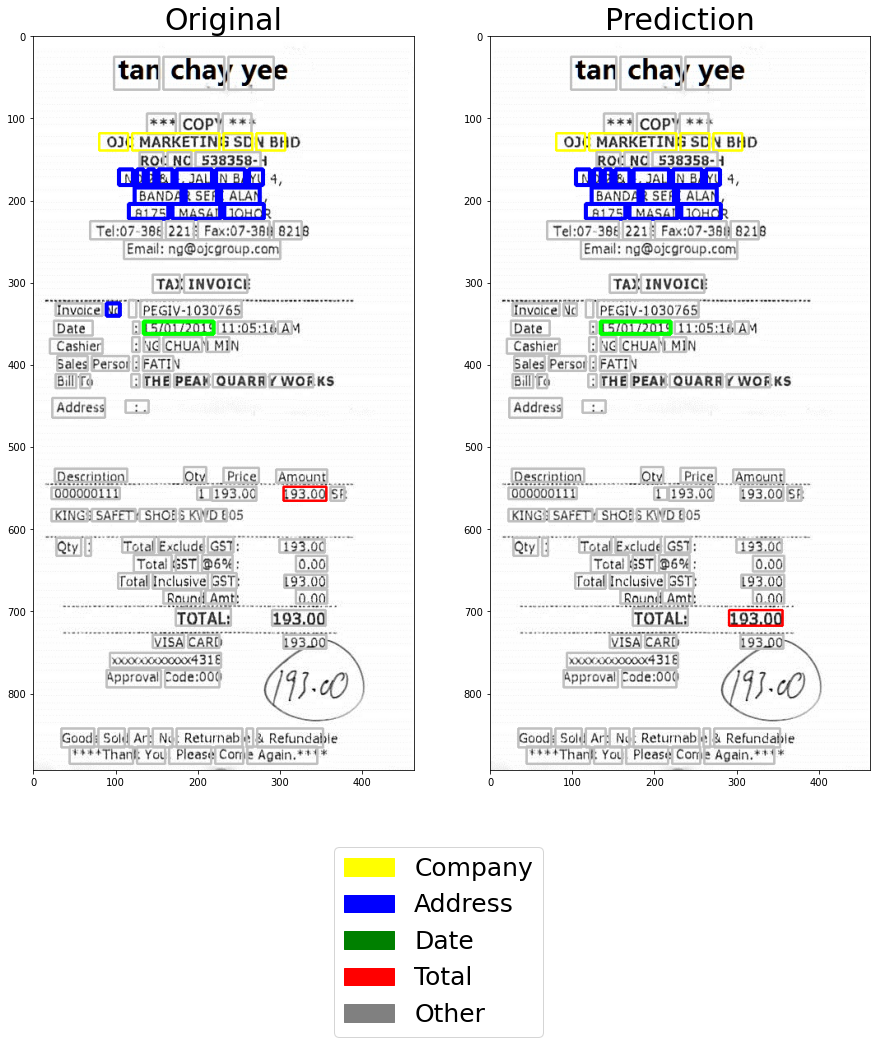

In [56]:
display_prediction(merged_groups[0], 'test')

Filename: X51005444046.jpg
/kaggle/input/sroie-testing/SROIE2019/test/img/X51005444046.jpg


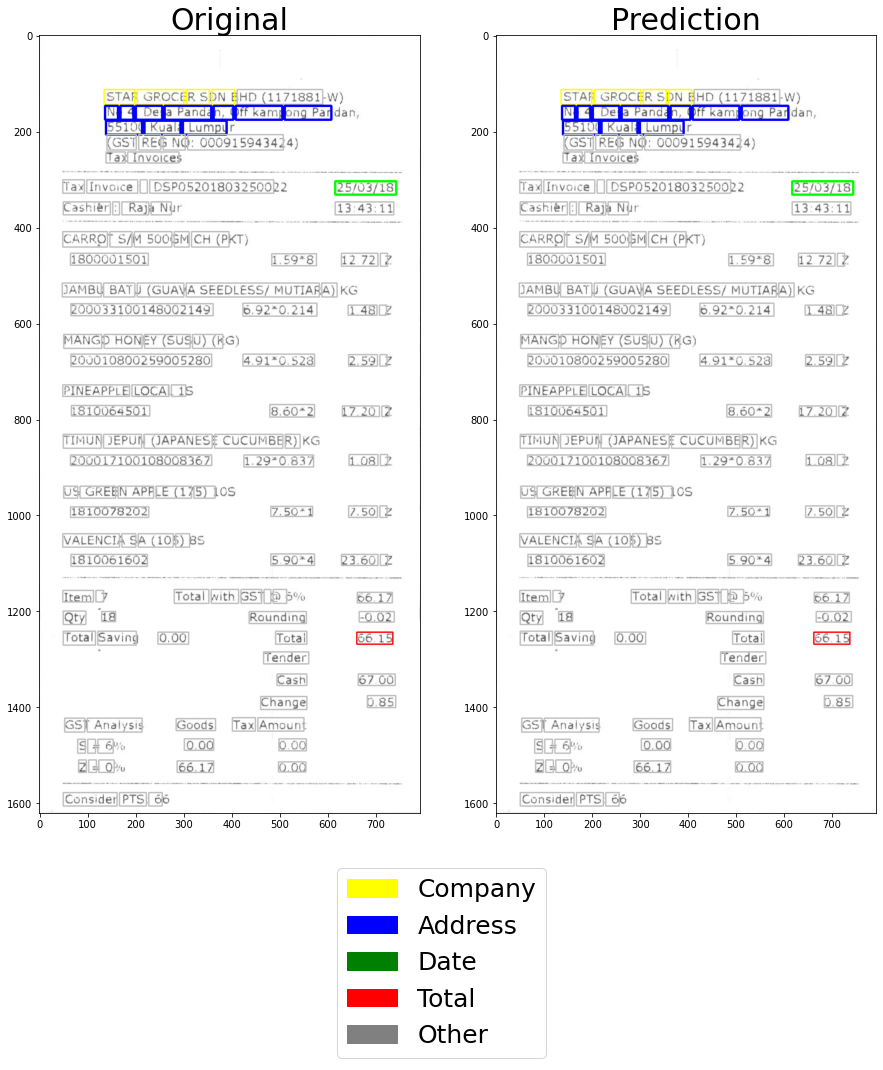

In [57]:


display_prediction(merged_groups[34], 'test')



Filename: X51005230605.jpg
/kaggle/input/sroie-testing/SROIE2019/test/img/X51005230605.jpg


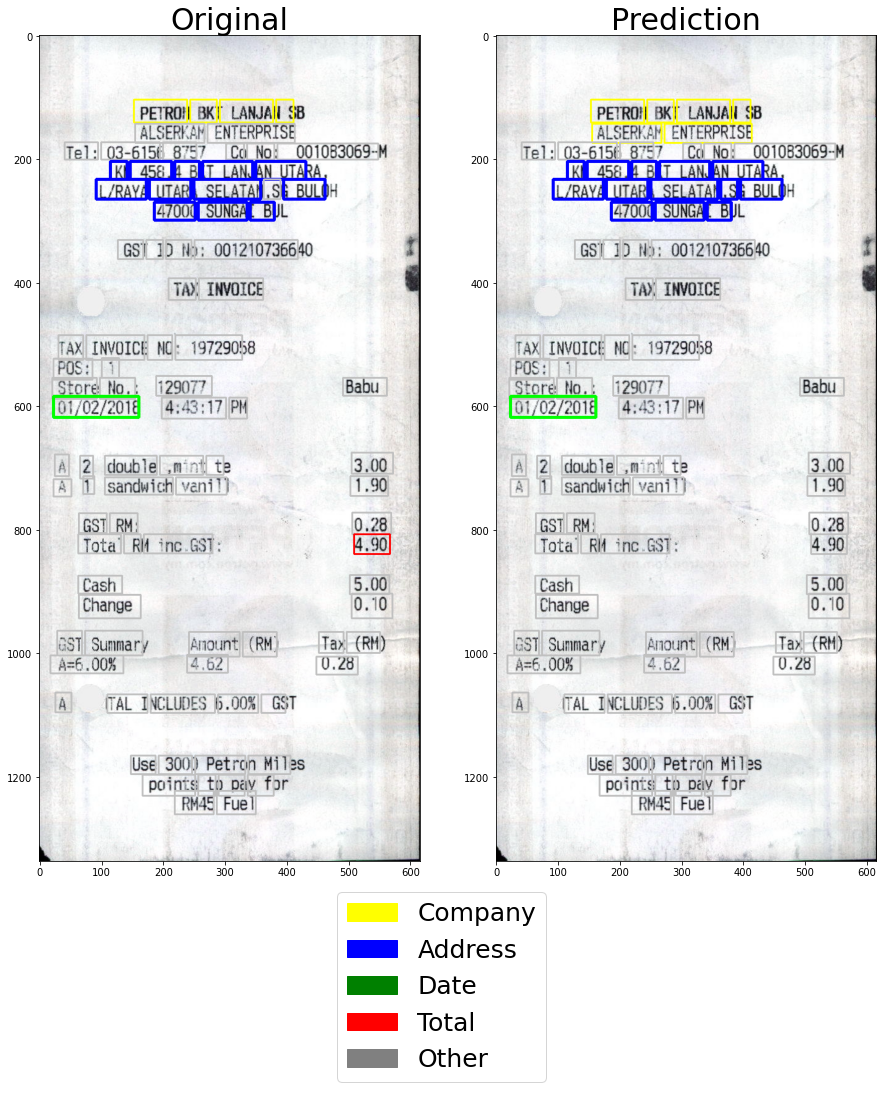

In [58]:
display_prediction(merged_groups[3], 'test')

<h2>You can further check other outputs by following the botton cell</h2>

Filename: X51005230621.jpg
/kaggle/input/sroie-testing/SROIE2019/test/img/X51005230621.jpg


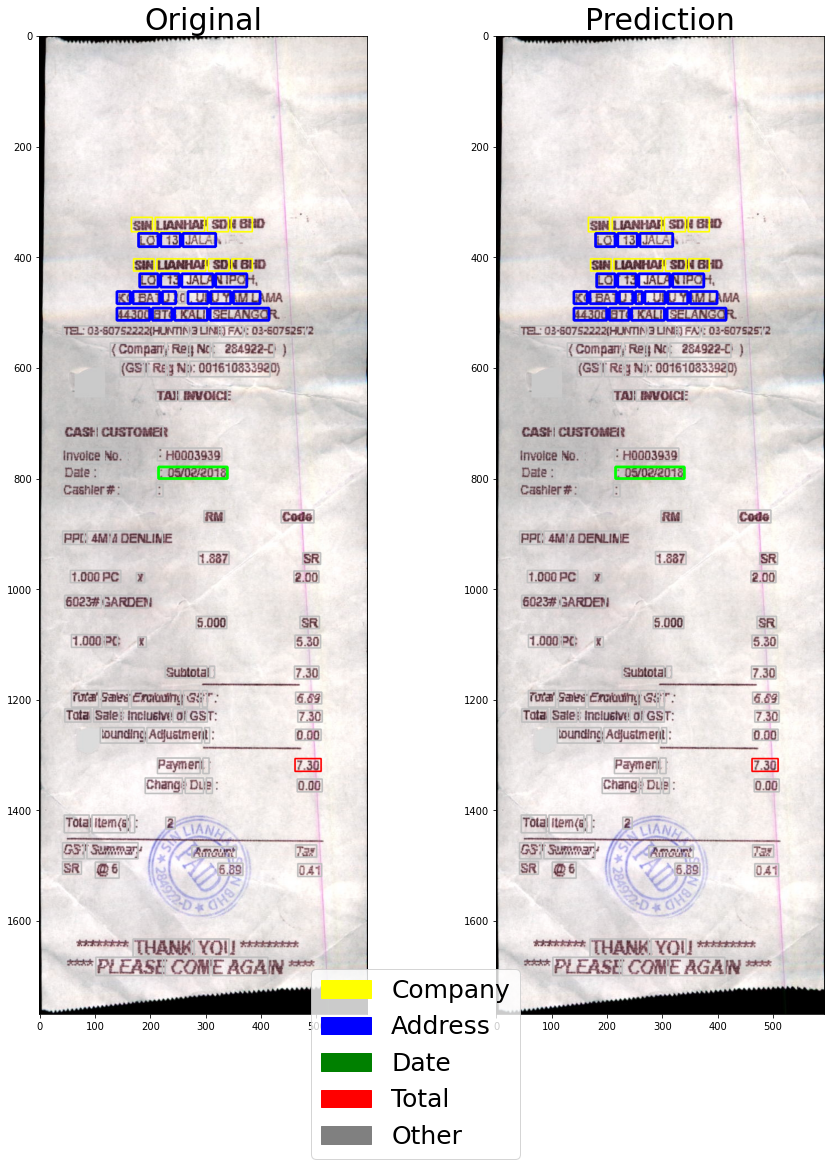

In [64]:
#Try out different values of n to see the predicted output
n = 5
display_prediction(merged_groups[n], 'test')

,prediction_category
0,O
1,O
2,O
3,O
4,O
...,...
39670,O
39671,O
39672,O
39673,O


In [59]:
df = merged_groups[2][1]
df.head()

,name,bbox,size,image,true_category,prediction_category
205,PERNIAGAAN,380 241 498 266,992 1403,X51005200931,S-COMPANY,S-COMPANY
206,ZHENG,503 241 562 266,992 1403,X51005200931,S-COMPANY,S-COMPANY
207,HUI,567 241 602 266,992 1403,X51005200931,S-COMPANY,S-COMPANY
208,JM0326955-V,459 267 546 282,992 1403,X51005200931,O,O
209,NO.59,416 286 454 301,992 1403,X51005200931,S-ADDRESS,S-ADDRESS


In [60]:
df1 = df.drop(['size','image','true_category'], axis = 1)
print(df1)

            name               bbox prediction_category
205   PERNIAGAAN    380 241 498 266           S-COMPANY
206        ZHENG    503 241 562 266           S-COMPANY
207          HUI    567 241 602 266           S-COMPANY
208  JM0326955-V    459 267 546 282                   O
209        NO.59    416 286 454 301           S-ADDRESS
..           ...                ...                 ...
350          ARE  451 1136 477 1155                   O
351          NOT  482 1136 508 1155                   O
352   RETURNABLE  513 1136 602 1155                   O
353        THANK  450 1160 490 1175                   O
354         YOU.  495 1160 527 1175                   O

[150 rows x 3 columns]


In [61]:
csv_data = df1.to_csv()
print(csv_data)

,name,bbox,prediction_category
205,PERNIAGAAN,380 241 498 266,S-COMPANY
206,ZHENG,503 241 562 266,S-COMPANY
207,HUI,567 241 602 266,S-COMPANY
208,JM0326955-V,459 267 546 282,O
209,NO.59,416 286 454 301,S-ADDRESS
210,JALAN,459 286 497 301,S-ADDRESS
211,PERMAS,502 286 548 301,S-ADDRESS
212,9/5,553 286 576 301,S-ADDRESS
213,BANDAR,404 304 455 320,S-ADDRESS
214,BARU,460 304 494 320,S-ADDRESS
215,PERMAS,499 304 550 320,S-ADDRESS
216,JAYA,555 304 589 320,S-ADDRESS
217,81750,427 319 471 338,S-ADDRESS
218,JOHOR,476 319 520 338,S-ADDRESS
219,BAHRU,525 319 569 338,S-ADDRESS
220,TEL:07-386,386 337 467 353,O
221,7524,472 337 504 353,O
222,FAX:07-386,509 337 590 353,O
223,3793,595 337 627 353,O
224,GST,436 361 459 376,O
225,NO:,464 361 487 376,O
226,000800689824,492 361 585 376,O
227,SIMPLIFIED,422 389 504 405,O
228,TAX,509 389 533 405,O
229,INVOICE,538 389 595 405,O
230,GOGIANT,332 417 389 431,O
231,ENGINEERING,394 417 484 431,O
232,(M),489 417 513 431,O
233,SDN,518 417 542 431,O
234,BHD,547 417 5

In [62]:
import os
dire = os.getcwd()
print(dire)
%cd /kaggle/working/unilm/layoutlm/deprecated/examples/seq_labeling
!ls

/kaggle/working/unilm/layoutlm/deprecated/examples/seq_labeling
/kaggle/working
output		preprocess.py  run_seq_labeling.py  unilm
prediction.jpg	preprocess.sh  runs
